# Spot-check the sparse tensor implementation

Updated December 2021


gully


In [1]:
%config Completer.use_jedi = False

In [2]:
import torch
from blase.emulator import PhoenixEmulator
import matplotlib.pyplot as plt
from gollum.phoenix import PHOENIXSpectrum
import numpy as np
from tqdm.notebook import tqdm

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
device

'cpu'

### Make a tensor composed of $N_{lines}$ sparsely spaced spectral lines.

I have experimentally verified that this notebook works with up to 500,000 lines.  You may wish to turn off overplotting all the lines for $N_{lines}>500$.  Also, the amplitudes become unphysical and the spectrum can become negative because we are adding flux loss and not opacity.

In [4]:
spectrum = PHOENIXSpectrum(teff=4700, logg=4.5, wl_lo=8019, wl_hi=12845)
spectrum = spectrum.divide_by_blackbody()
spectrum = spectrum.normalize()
continuum_fit = spectrum.fit_continuum(polyorder=5)
spectrum = spectrum.divide(continuum_fit, handle_meta="ff")

In [5]:
active_lower, active_upper = 8079, 12785
line_threshold_lower, line_threshold_upper = 8049, 12815

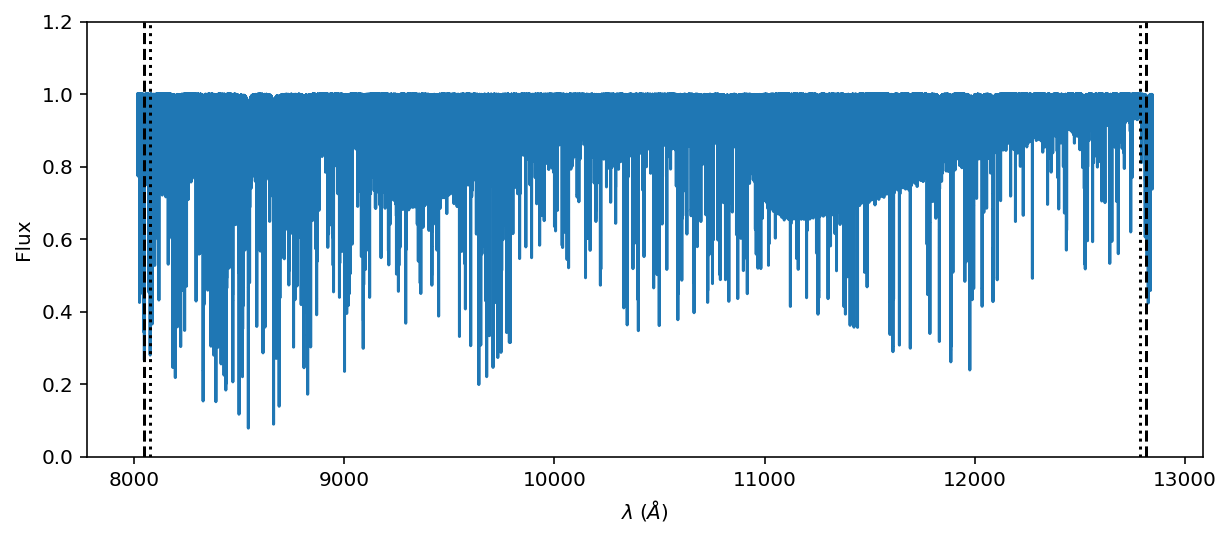

In [6]:
ax = spectrum.plot(ylo=0);
ax.axvline(8049, linestyle='dashed', color='k')
ax.axvline(12815, linestyle='dashed', color='k')

ax.axvline(8079, linestyle='dotted', color='k')
ax.axvline(12785, linestyle='dotted', color='k');

In [7]:
# Numpy arrays: 1 x N_pix
wl_native = spectrum.wavelength.value
flux_native = spectrum.flux.value

In [8]:
# Create the emulator
emulator = PhoenixEmulator(wl_native, flux_native, prominence=0.02)
emulator.to(device)

PhoenixEmulator()

## Now try the sparse Emulator

In [9]:
from blase.emulator import SparsePhoenixEmulator

In [10]:
sparse_emulator = SparsePhoenixEmulator(wl_native, flux_native, prominence=0.02)

100%|████████████████████████████████| 6487/6487 [01:25<00:00, 76.17it/s]


In [11]:
output = sparse_emulator.forward()

Yay! it works!

In [12]:
output

tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
       dtype=torch.float64, grad_fn=<ExpBackward>)

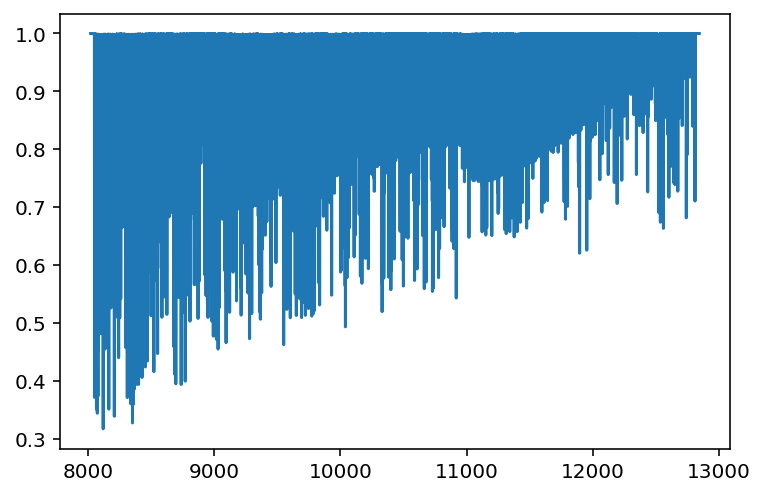

In [13]:
plt.plot(sparse_emulator.wl_native, output.detach().numpy());

Awesome, it works!  Let's try to use `requires_grad=True`...